# Multivariate Time-Series Forecasting: Predict Iron Prices

### Import libs

In [287]:
import numpy as np
import pandas as pd
import datetime as dt

import matplotlib.pyplot as plt
from pylab import rcParams


from sklearn.preprocessing import StandardScaler

from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.optimizers import Adam


# Create date column for both dataframes:
# this function takes a string object which is in a date format and covert it to a date object
def str_to_datetime(s):
  split = s.split('/')
  month, day, year = int(split[0]), int(split[1]), int(split[2])
  return dt.datetime(year=year, month=month, day=day)

def str_to_datetime_ii(s):
  split = s.split('-')
  year, month, day = int(split[0]), int(split[1]), int(split[2])
  return dt.datetime(year=year, month=month, day=day)

## Part 1: Data preprocessing

###  Read and load the data; we want to select the features for the training and prediction and extract the date column then make it the index

Index & Date columns...

In [288]:
# read the data and convert index to date:

#            iron_12mm
df_iron_12mm= pd.read_excel(r'C:\Users\fnafisa\WORKSPACE\professional\Project PoC\Input\data\iron ore\price 12mm iron.xlsx')
# create column to concatenate the day, month and year
df_iron_12mm['date'] = df_iron_12mm['month'].map(str)+ '/'  + '1' + '/' + df_iron_12mm['year'].map(str)
# apply the function str_to_datetime on df_iron_12mm & assign date to be the new indexes
df_iron_12mm['date'] = df_iron_12mm['date'].apply(str_to_datetime)
df_iron_12mm.index = df_iron_12mm.pop('date')
# we keep only the needed columns
df_iron_12mm= pd.DataFrame(df_iron_12mm['price'])
df_iron_12mm.columns= ['iron_12mm']

#           iron_10mm
df_iron_10mm= pd.read_excel(r'C:\Users\fnafisa\WORKSPACE\professional\Project PoC\Input\data\iron ore\price 10mm iron.xlsx')
# create column to concatenate the day, month and year
df_iron_10mm['date'] = df_iron_10mm['month'].map(str)+ '/'  + '1' + '/' + df_iron_10mm['year'].map(str)
# apply the function str_to_datetime on df_iron_10mm & assign date to be the new indexes
df_iron_10mm['date'] = df_iron_10mm['date'].apply(str_to_datetime)
df_iron_10mm.index = df_iron_10mm.pop('date')
# we keep only the needed columns
df_iron_10mm= pd.DataFrame(df_iron_10mm['price'])
df_iron_10mm.columns= ['iron_10mm']

#           oil
df_oil_brent= pd.read_csv(r'C:\Users\fnafisa\WORKSPACE\professional\Project PoC\Input\data\Oil\Brent Oil Futures Historical Data; monthly.csv')
df_oil_brent['Date'] = df_oil_brent['Date'].apply(str_to_datetime)
df_oil_brent.index = df_oil_brent.pop('Date')
# we keep only the needed columns
df_oil_brent= pd.DataFrame(df_oil_brent['Price'])
df_oil_brent.columns= ['oil_brent']

#           TASI
df_TASI= pd.read_csv(r'C:\Users\fnafisa\WORKSPACE\professional\Project PoC\Input\data\Markets\Tadawul All Share Historical Data monthly.csv')
df_TASI['Date'] = df_TASI['Date'].apply(str_to_datetime)
df_TASI.index = df_TASI.pop('Date')
# we keep only the needed columns
df_TASI= pd.DataFrame(df_TASI['Price'])
df_TASI.columns= ['tasi']

#           gold
df_gold= pd.read_csv(r'C:\Users\fnafisa\WORKSPACE\professional\Project PoC\Input\data\gold\Gold Futures Historical Data monthly.csv')
df_gold['Date'] = df_gold['Date'].apply(str_to_datetime)
df_gold.index = df_gold.pop('Date')
# we keep only the needed columns
df_gold= pd.DataFrame(df_gold['Price'])
df_gold.columns= ['gold']

#           interest rates
df_interest_rates= pd.read_csv(r'C:\Users\fnafisa\WORKSPACE\professional\Project PoC\Input\data\Fed fund rates\FEDFUNDS.csv')
df_interest_rates['Date'] = df_interest_rates['DATE'].apply(str_to_datetime_ii)
df_interest_rates.index = df_interest_rates.pop('Date')
# we keep only the needed columns
df_interest_rates= pd.DataFrame(df_interest_rates['FEDFUNDS'])
df_interest_rates.columns= ['interest_rate']




  ----->>> JOIN <<<-----

In [289]:
# join the two dataframes based on date index to create the traing dataset
# dataset_train = pd.merge(df_iron_12mm,df_iron_10mm, how='left', left_index=True, right_index=True)
dataset_train = pd.merge(df_iron_12mm,df_oil_brent, how='left', left_index=True, right_index=True)
dataset_train = pd.merge(dataset_train,df_TASI, how='left', left_index=True, right_index=True)
dataset_train = pd.merge(dataset_train,df_gold, how='left', left_index=True, right_index=True)
dataset_train = pd.merge(dataset_train,df_interest_rates, how='left', left_index=True, right_index=True)


dataset_train['historical']= dataset_train['iron_12mm'].shift(1)

dataset_train['historical'].fillna(value=dataset_train['historical'].mean(), inplace=True)

# make the dataframe on a monthly basis
dataset_train= dataset_train.to_period(freq='m')

dataset_train.info()

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 117 entries, 2013-01 to 2022-09
Freq: M
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   iron_12mm      117 non-null    float64
 1   oil_brent      117 non-null    float64
 2   tasi           117 non-null    object 
 3   gold           117 non-null    object 
 4   interest_rate  117 non-null    float64
 5   historical     117 non-null    float64
dtypes: float64(4), object(2)
memory usage: 6.4+ KB


check for null values:

In [293]:
# select features (columns) to be involved into training and predictions
cols= list(dataset_train)[:]


# EXTRACT dates:
# store the date index in a list 
datelist_train= dataset_train.index.strftime('%Y-%m')
datelist_train= [dt.datetime.strptime(date, '%Y-%m').date() for date in datelist_train]


print('Training set shape == {}'.format(dataset_train.shape))
print('All timestamps == {}'.format(len(datelist_train)))
print('Featured selected: {}'.format(cols))
print('Sample of date list: {}...{}'.format(datelist_train[0:2], datelist_train[-3:-1]))


# note!
# we save both the columns and time series(date), because when we convert dataset_train using .to_numpy() it will then lose the columns and will reset the index

Training set shape == (117, 6)
All timestamps == 117
Featured selected: ['iron_12mm', 'oil_brent', 'tasi', 'gold', 'interest_rate', 'historical']
Sample of date list: [datetime.date(2013, 1, 1), datetime.date(2013, 2, 1)]...[datetime.date(2022, 7, 1), datetime.date(2022, 8, 1)]


In [312]:
dataset_train

,iron_12mm,oil_brent,tasi,gold,interest_rate,historical
date,,,,,,
2013-01,2964.917,114.54,"7,043.55","1,662.00",0.14,2615.09244
2013-02,2964.750,110.42,"6,998.33","1,578.90",0.15,2964.91700
2013-03,2964.942,109.79,"7,125.73","1,595.70",0.14,2964.75000
2013-04,2964.917,102.04,"7,179.80","1,472.70",0.15,2964.94200
2013-05,2964.917,100.20,"7,404.12","1,393.00",0.11,2964.91700
...,...,...,...,...,...,...
2022-05,4000.960,115.60,"12,921.74","1,848.40",0.77,4032.60000
2022-06,3704.880,109.03,"11,523.25","1,812.00",1.21,4000.96000
2022-07,3595.940,103.97,"12,199.08","1,771.50",1.68,3704.88000


In [329]:
dataset_train= pd.read_excel(r'C:\Users\fnafisa\WORKSPACE\professional\Project PoC\Input\data\Construction materials\segregated\حديد تسليح 12مم وطني.xlsx')
dataset_train.index= dataset_train.pop('date')
dataset_train= dataset_train.to_period(freq='m')
# select features (columns) to be involved into training and predictions
cols= list(dataset_train)[:]


# EXTRACT dates:
# store the date index in a list 
datelist_train= dataset_train.index.strftime('%Y-%m')
datelist_train= [dt.datetime.strptime(date, '%Y-%m').date() for date in datelist_train]


print('Training set shape == {}'.format(dataset_train.shape))
print('All timestamps == {}'.format(len(datelist_train)))
print('Featured selected: {}'.format(cols))
print('Sample of date list: {}...{}'.format(datelist_train[0:2], datelist_train[-3:-1]))

Training set shape == (117, 6)
All timestamps == 117
Featured selected: ['price', 'oil_brent', 'tasi', 'gold', 'interest_rate', 'historical']
Sample of date list: [datetime.date(2013, 1, 1), datetime.date(2013, 2, 1)]...[datetime.date(2022, 7, 1), datetime.date(2022, 8, 1)]


In [330]:
dataset_train

,price,oil_brent,tasi,gold,interest_rate,historical
date,,,,,,
2013-01,2964.917,114.54,"7,043.55","1,662.00",0.14,2615.09244
2013-02,2964.750,110.42,"6,998.33","1,578.90",0.15,2964.91700
2013-03,2964.942,109.79,"7,125.73","1,595.70",0.14,2964.75000
2013-04,2964.917,102.04,"7,179.80","1,472.70",0.15,2964.94200
2013-05,2964.917,100.20,"7,404.12","1,393.00",0.11,2964.91700
...,...,...,...,...,...,...
2022-05,4000.960,115.60,"12,921.74","1,848.40",0.77,4032.60000
2022-06,3704.880,109.03,"11,523.25","1,812.00",1.21,4000.96000
2022-07,3595.940,103.97,"12,199.08","1,771.50",1.68,3704.88000


###  Shaping and transformation

In [331]:
# make sure there are no commas in any number
dataset_train= dataset_train[cols].astype(str)
for i in cols: #['iron_12mm', 'oil_brent', 'tasi', 'gold', 'interest_rate', 'historical']
    for j in range(0, len(dataset_train)):
        dataset_train[i][j]= dataset_train[i][j].replace(',','')
dataset_train= dataset_train[cols].astype(float)

# Using multiple predictors (features)
# we need convert (reshape) to a matrix(array) using .to_numpy
training_set= dataset_train.to_numpy()
print('Shape of training set == {}.'.format(training_set.shape))

Shape of training set == (117, 6).


In [332]:
# Feature scaling hence features vary in range
sc= StandardScaler()
training_set_scaled= sc.fit_transform(training_set)

sc_predict= StandardScaler()
A= sc_predict.fit_transform(training_set[:,0:1]) # our target (iron_12mm) / the dependant variable

print('')


## Part 2: Modeling

###  Build the model architecture and Set up the WINDOWED DATAFRAME 

In [333]:
range(dataset_train.shape[1]-1)

range(0, 5)

In [334]:
training_set_scaled[0:1,1:dataset_train.shape[1]]

array([[ 1.87505343e+00, -8.56059301e-01,  9.06211793e-01,
        -7.07336230e-01,  1.88915200e-15]])

In [335]:
# Create a data structure with timestamps
X_train= []
y_train= []
n_future= 6 # number of moths to be predicted
n_past= 12 # the size of the windowed dataframe

for i in range(n_past, len(training_set_scaled) - n_future +1):
    X_train.append(training_set_scaled[i - n_past:i, 1:dataset_train.shape[1]])
    y_train.append(training_set_scaled[i + n_future - 1:i + n_future, 0])

X_train, y_train = np.array(X_train), np.array(y_train)
print('X_train shape == {}.'.format(X_train.shape))
print('y_train shape == {}.'.format(y_train.shape))



# Model structure
model= Sequential()
model.add(LSTM(units=32, return_sequences=True, input_shape=(n_past, X_train.shape[-1])))
model.add(Dropout(.25))
model.add(LSTM(units=10, return_sequences=False))
model.add(Dropout(.20))
model.add(Dense(units=1, activation='linear'))
model.compile(optimizer= Adam(learning_rate=.015), loss= 'mean_squared_error')

X_train shape == (100, 12, 5).
y_train shape == (100, 1).


In [337]:
%%time
es = EarlyStopping(monitor='val_loss', min_delta=1e-10, patience=20, verbose=1)
rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, verbose=1)
mcp = ModelCheckpoint(filepath='weights.h5', monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True)

tb = TensorBoard('logs')

history = model.fit(X_train, y_train, shuffle=True, epochs=50, callbacks=[es, rlr, mcp, tb], validation_split=0.3, verbose=1, batch_size=32)

Epoch 1/50
1/3 [=========>....................] - ETA: 0s - loss: 0.0903
Epoch 1: val_loss improved from inf to 2.07095, saving model to weights.h5
3/3 [==============================] - 0s 45ms/step - loss: 0.0734 - val_loss: 2.0710 - lr: 0.0037
Epoch 2/50
1/3 [=========>....................] - ETA: 0s - loss: 0.0733
Epoch 2: val_loss improved from 2.07095 to 2.06724, saving model to weights.h5
3/3 [==============================] - 0s 36ms/step - loss: 0.0660 - val_loss: 2.0672 - lr: 0.0037
Epoch 3/50
1/3 [=========>....................] - ETA: 0s - loss: 0.0751
Epoch 3: val_loss did not improve from 2.06724
3/3 [==============================] - 0s 29ms/step - loss: 0.0743 - val_loss: 2.0737 - lr: 0.0037
Epoch 4/50
1/3 [=========>....................] - ETA: 0s - loss: 0.0495
Epoch 4: val_loss did not improve from 2.06724
3/3 [==============================] - 0s 26ms/step - loss: 0.0637 - val_loss: 2.0895 - lr: 0.0037
Epoch 5/50
1/3 [=========>....................] - ETA: 0s - loss

###  training and testing
## Part 3: Forcasting
### Step 5: Predict the future

In [340]:
# Generate list of sequence of months for predictions w datetime type
datelist_future = pd.date_range(datelist_train[-1], periods=n_future, freq='1m').tolist()
datelist_future_= []
for d in datelist_future:
    d= d + dt.timedelta(days=1)
    d= d.date()
    datelist_future_.append(d)
# (datelist_future_)


# Perform predictions
predictions_future = model.predict(X_train[-n_future:])

predictions_train = model.predict(X_train[n_past:])

def datetime_to_timestamp(x):
    '''
        x : a given datetime value (datetime.date)
    '''
    return dt.strptime(x.strftime('%Y%m%d'), '%Y%m%d')


y_pred_future = sc_predict.inverse_transform(predictions_future)
y_pred_train = sc_predict.inverse_transform(predictions_train)

PREDICTIONS_FUTURE = pd.DataFrame(y_pred_future, columns=['predicted']).set_index(pd.Series(datelist_future_))
# PREDICTION_TRAIN = pd.DataFrame(y_pred_train, columns=['predicted']).set_index(pd.Series(datelist_train[2 * n_past + n_future -1:]))
PREDICTION_TRAIN = pd.DataFrame(y_pred_train, columns=['predicted']).set_index(pd.Series(datelist_train[2 * n_past + n_future -1:]))

# Convert  to  for PREDCITION_TRAIN
PREDICTION_TRAIN.index = PREDICTION_TRAIN.index#.to_series()#.apply(datetime_to_timestamp)



3/3 [==============================] - 0s 4ms/step


C:\Users\Administrator\AppData\Local\Temp\ipykernel_16608\867455051.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  res= PREDICTION_TRAIN.append(PREDICTIONS_FUTURE)


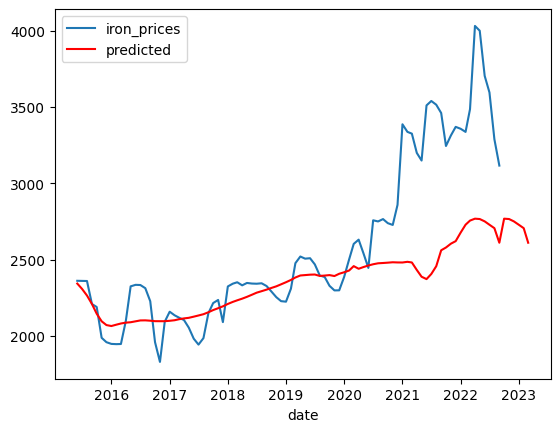

In [341]:
PREDICTION_TRAIN
res= PREDICTION_TRAIN.append(PREDICTIONS_FUTURE)
res['iron_prices']= df_iron_12mm

res['date']= res.index
res.columns[-1]
df= res

ax = plt.gca()
df.plot(kind='line',x=res.columns[-1],y='iron_prices',ax=ax)
df.plot(kind='line',x=res.columns[-1],y='predicted', color='red', ax=ax)


plt.show()

In [328]:
res.to_csv(r'C:\Users\fnafisa\WORKSPACE\professional\Project PoC\output\predictions.csv', encoding='utf-8', index=False)
